In [ ]:
import os
import gzip
import numpy as np
import pandas as pd
import time
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D


## 1. Data Loading & Preprocessing

### Data Loading

Load data từ các file đã tải về.

In [256]:
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

Vì bộ dữ liệu đã được chia sẵn tỉ lệ train - test nên ta chỉ cần load lên và sử dụng.

In [257]:
X_train, y_train = load_mnist('data/mnist', kind='train')
X_test, y_test = load_mnist('data/mnist', kind='t10k')

### Basic EDA

#### Kiểm tra kích thước, giá trị của tập Train, Test

In [258]:
print("X_train shape: " + str(X_train.shape))
print("y_train shape: " + str(y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("y_test shape: " + str(y_test.shape))

X_train shape: (60000, 784)
y_train shape: (60000,)
X_test shape: (10000, 784)
y_test shape: (10000,)


In [259]:
print("Feature Values: \nFrom " + str(np.min(X_train)) + " to " + str(np.max(X_train)))
print("Data type: " + str(X_train.dtype))
print("\nLabel Values: ")
print(set(list(y_train)))
print("Data type: " + str(y_train.dtype))

Feature Values: 
From 0 to 255
Data type: uint8

Label Values: 
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Data type: uint8


#### Kiểm tra phân phối của từng class

In [260]:
# Tạo 1 dataframe chứa các label để quan sát
train_label = pd.DataFrame()
train_label['label'] = pd.DataFrame(y_train)

In [261]:
len(train_label['label'].unique())

10

In [262]:
train_label['label'].value_counts().sort_index()

label
0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
Name: count, dtype: int64

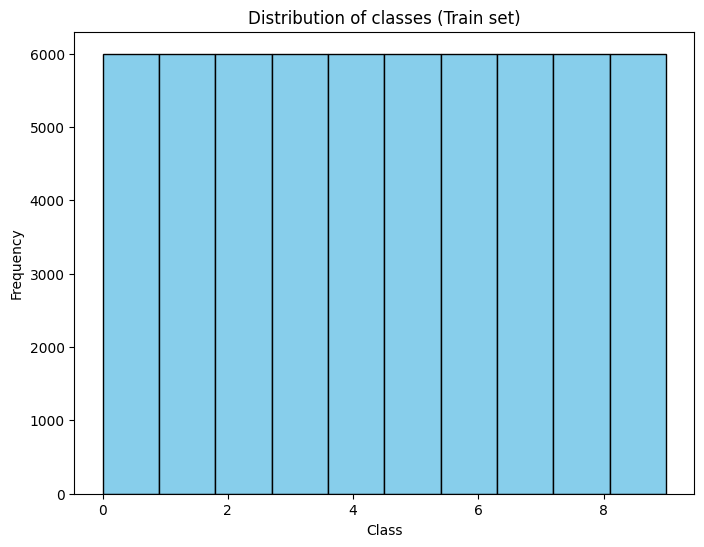

In [263]:
# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(y_train, bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Distribution of classes (Train set)')
plt.show()

**Nhận xét nhanh:**

*  Bộ dữ liệu có tổng cộng 70000 quan trắc, trong đó chia ra 60000 cho tập Train và 10000 cho tập Test.
*  Mỗi quan trắc là một bức ảnh greyscale có kích thước 28 x 28, sau khi load thì dữ liệu có kiểu np.array nên mỗi quan trắc có 784 feature.
*  Khoảng giá trị của mỗi quan trắc là từ 0 tới 255, đây là khoảng giá trị hay dùng trong các bức ảnh greyscale.
*  Bộ dữ liệu có 10 class, mỗi class là một kiểu quần áo như 'Trouser', 'Pullover', 'Dress', 'Coat'... và đã được số hóa thành các giá trị từ 0 tới 9.
*  Từ hai đồ thị, ta có thể thấy bộ dữ liệu này hoàn toàn cân bằng giữa các class khi ở cả tập Train và tập Test, cả 10 class đều có số lượng quan trắc bằng nhau (và lần lượt bằng 6000 và 1000).

### Trực quan hóa một vài mẫu

In [264]:
class_names = [
'T-shirt/top',
'Trouser',
'Pullover',
'Dress',
'Coat',
'Sandal',
'Shirt',
'Sneaker',
'Bag',
'Ankle boot'
]

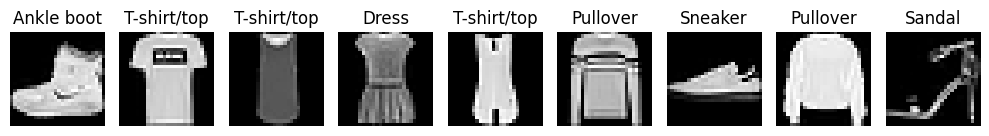

In [265]:
def plot_fashion_mnist_samples(X_train, num_samples=9):
    plt.figure(figsize=(10, 2))  # Create a figure for plotting
    for i in range(num_samples):
        # Reshape each image from 784 to 28x28
        image = X_train[i].reshape((28, 28))
        label = y_train[i]
        plt.subplot(1, num_samples, i + 1)  # Add subplots for each sample
        plt.title(class_names[label])
        plt.imshow(image, cmap='gray')  # Display the image in grayscale
        plt.axis('off')  # Turn off the axis for cleaner visualization
    plt.tight_layout()  # Adjust subplots to fit into the figure
    plt.show()  # Display the plot

# Example usage:
plot_fashion_mnist_samples(X_train)

### Normalization

In [266]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [267]:
print("Feature Values: \nFrom " + str(np.min(X_train)) + " to " + str(np.max(X_train)))

Feature Values: 
From 0.0 to 1.0


**Nhận xét nhanh:**

Trong các thuật toán ta sử dụng trong bài này, Logistic Regression không bị ảnh hưởng nhiều bởi việc chuẩn hóa dữ liệu nên ta thực chất không cần phải chuẩn hóa trước khi sử dụng. Tuy nhiên, Support Vector Machine (SVM) lại cần chuẩn hóa dữ liệu về khoảng [0, 1] hoặc [-1, 1] để có thể chạy tốt nên để đơn giản ta sẽ chuẩn hóa toàn bộ dữ liệu trước khi dùng cả 2 thuật toán trên.

### Sampling

In [268]:
# df_train = pd.DataFrame(X_train)
# df_train['label'] = pd.DataFrame(y_train)
# df_test = pd.DataFrame(X_test)
# df_test['label'] = pd.DataFrame(y_test)

In [269]:
# data_train = df_train.sample(frac=0.1)
# data_test = df_test.sample(frac=0.1)

In [270]:
# X_train = data_train.drop(['label'], axis=1)
# y_train = data_train['label']
# X_test = data_test.drop(['label'], axis=1)
# y_test = data_test['label']

## 2. Modeling

### Logistic Regression

In [271]:
start_time = time.time()

# Train a Logistic Regression Classifier
logistic_model = LogisticRegression(verbose=1, random_state=0)
logistic_model.fit(X_train, y_train)

end_time = time.time()
logistic_train_time = end_time - start_time
print("Runtime: {:.2f} seconds".format(end_time - start_time))

Runtime: 9.68 seconds


c:\Users\admin\anaconda3\envs\gan\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [272]:
start_time = time.time()

# Make predictions on the test set
y_pred_logistic = logistic_model.predict(X_test)

end_time = time.time()
logistic_pred_time = end_time - start_time
print("Runtime: {:.2f} seconds".format(end_time - start_time))

Runtime: 0.02 seconds


In [273]:
# Evaluate the model
logistic_accuracy = accuracy_score(y_test, y_pred_logistic)
logistic_precision = precision_score(y_test, y_pred_logistic, average='weighted')
logistic_recall = recall_score(y_test, y_pred_logistic, average='weighted')
logistic_f1 = f1_score(y_test, y_pred_logistic, average='weighted')

# Print key metrics
print(f"Accuracy: {logistic_accuracy:.4f}")
print(f"Precision: {logistic_precision:.4f}")
print(f"Recall: {logistic_recall:.4f}")
print(f"F1 Score: {logistic_f1:.4f}")

Accuracy: 0.8439
Precision: 0.8426
Recall: 0.8439
F1 Score: 0.8430


In [274]:
print(classification_report(y_test, y_pred_logistic))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1000
           1       0.98      0.96      0.97      1000
           2       0.72      0.73      0.73      1000
           3       0.83      0.87      0.85      1000
           4       0.73      0.76      0.75      1000
           5       0.94      0.93      0.93      1000
           6       0.62      0.56      0.59      1000
           7       0.90      0.94      0.92      1000
           8       0.93      0.94      0.94      1000
           9       0.95      0.94      0.95      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



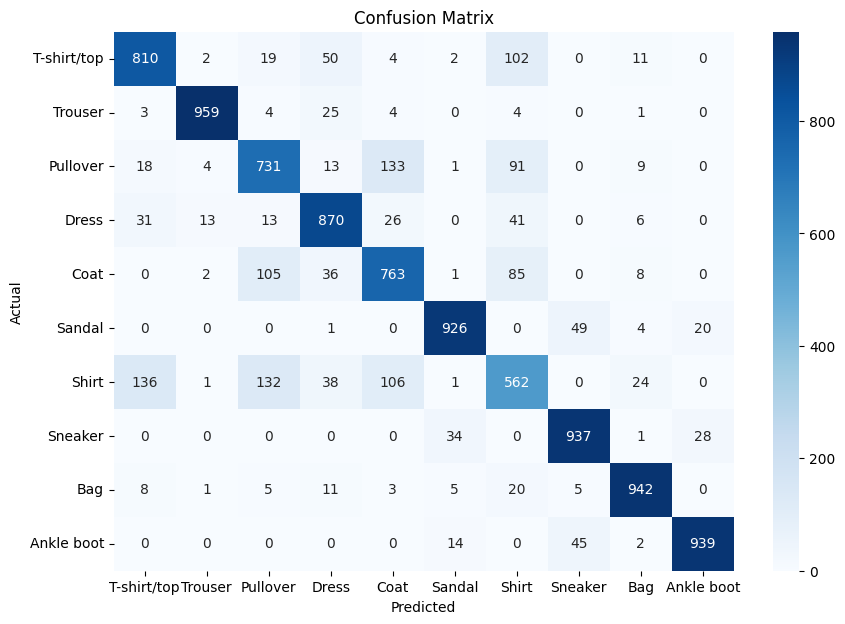

In [275]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_logistic)

# Display the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
                         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'],
            yticklabels=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
                         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Nhận xét nhanh:**

*  Các class được dự đoán đúng nhiều (trên 900) là: 'Trouser', 'Sandal', 'Sneaker', 'Bag', 'Ankle boot'.
*  Các class còn lại đều dự đoán sai tương đối, trong đó có class 'Shirt' là tệ nhất - chỉ đúng 562/1000 sample.
*  Các class 'T-shirt/top', 'Pullover', 'Coat', 'Shirt' ngoài việc đều có số sample dự đoán đúng thấp còn có một pattern nổi bật là chúng bị nhầm lẫn với nhau - tức là dự đoán sai là vì hầu hết là dự đoán thành 1 trong 3 class còn lại trong 4 class.

⇒ Kết quả trên hợp lý với thực tế vì các món quần áo như 'T-shirt/top', 'Pullover', 'Coat', 'Shirt' cũng có thiết kế khá giống nhau cộng với việc bức hình là ảnh greyscale và chỉ có kích thước 28 x 28 pixel càng làm cho các món trên dễ nhầm lẫn với nhau hơn.

⇒ Thậm chí với chính con người cũng không thể phân loại đúng 100% với bộ dữ liệu này. Cụ thể là chỉ được Accuracy khoảng 83.5% khi dự đoán trên tập test. (Nguồn: https://github.com/zalandoresearch/fashion-mnist)

⇒ Ta có thể dự đoán mô hình có tốt hay không sẽ ảnh hưởng rất nhiều bởi việc có phân tách 4 class 'T-shirt/top', 'Pullover', 'Coat', 'Shirt' tốt hay không.


### SVM - RBF kernel

In [276]:
start_time = time.time()

svm_rbf_model = SVC(kernel='rbf', random_state=0)
svm_rbf_model.fit(X_train, y_train)

end_time = time.time()
svm_rbf_train_time = end_time - start_time
print("Runtime: {:.2f} seconds".format(end_time - start_time))

Runtime: 297.06 seconds


In [277]:
start_time = time.time()

y_pred_svm_rbf = svm_rbf_model.predict(X_test)

end_time = time.time()
svm_rbf_pred_time = end_time - start_time
print("Runtime: {:.2f} seconds".format(end_time - start_time))

Runtime: 137.42 seconds


In [278]:
# Evaluate the model
svm_rbf_accuracy = accuracy_score(y_test, y_pred_svm_rbf)
svm_rbf_precision = precision_score(y_test, y_pred_svm_rbf, average='weighted')
svm_rbf_recall = recall_score(y_test, y_pred_svm_rbf, average='weighted')
svm_rbf_f1 = f1_score(y_test, y_pred_svm_rbf, average='weighted')

# Print key metrics
print(f"Accuracy: {svm_rbf_accuracy:.4f}")
print(f"Precision: {svm_rbf_precision:.4f}")
print(f"Recall: {svm_rbf_recall:.4f}")
print(f"F1 Score: {svm_rbf_f1:.4f}")

Accuracy: 0.8829
Precision: 0.8824
Recall: 0.8829
F1 Score: 0.8824


In [279]:
print(classification_report(y_test, y_pred_svm_rbf))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84      1000
           1       0.99      0.96      0.98      1000
           2       0.79      0.82      0.80      1000
           3       0.87      0.89      0.88      1000
           4       0.81      0.81      0.81      1000
           5       0.96      0.95      0.96      1000
           6       0.72      0.66      0.69      1000
           7       0.93      0.95      0.94      1000
           8       0.97      0.98      0.97      1000
           9       0.96      0.95      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



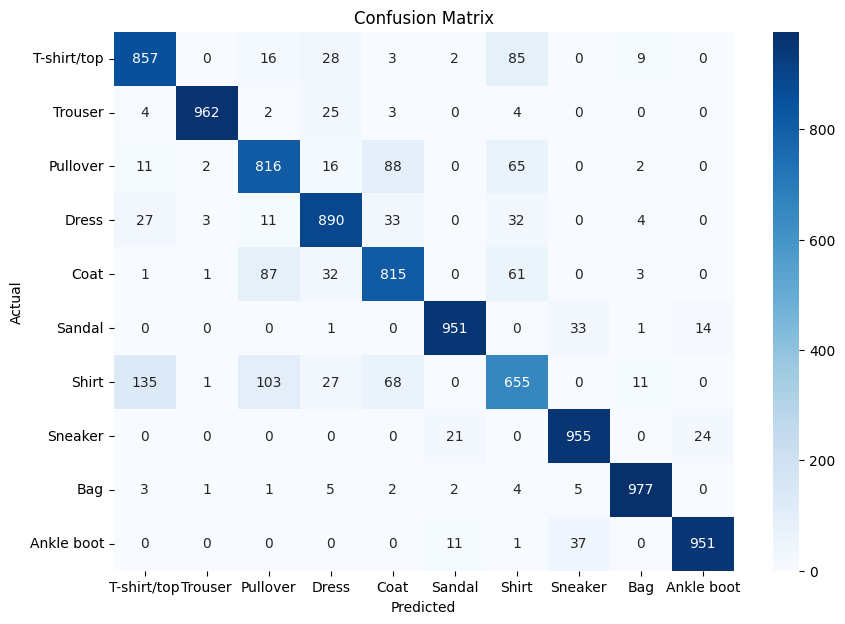

In [280]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_svm_rbf)

# Display the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
                         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'],
            yticklabels=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
                         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### SVM - Linear Kernel

In [281]:
start_time = time.time()

svm_linear_model = SGDClassifier(loss='hinge', random_state=0)
svm_linear_model.fit(X_train, y_train)

end_time = time.time()
svm_linear_train_time = end_time - start_time
print("Runtime: {:.2f} seconds".format(end_time - start_time))

Runtime: 27.47 seconds


In [282]:
start_time = time.time()

y_pred_svm_linear = svm_linear_model.predict(X_test)

end_time = time.time()
svm_linear_pred_time = end_time - start_time
print("Runtime: {:.2f} seconds".format(end_time - start_time))

Runtime: 0.03 seconds


In [283]:
# Evaluate the model
svm_linear_accuracy = accuracy_score(y_test, y_pred_svm_linear)
svm_linear_precision = precision_score(y_test, y_pred_svm_linear, average='weighted')
svm_linear_recall = recall_score(y_test, y_pred_svm_linear, average='weighted')
svm_linear_f1 = f1_score(y_test, y_pred_svm_linear, average='weighted')

# Print key metrics
print(f"Accuracy: {svm_linear_accuracy:.4f}")
print(f"Precision: {svm_linear_precision:.4f}")
print(f"Recall: {svm_linear_recall:.4f}")
print(f"F1 Score: {svm_linear_f1:.4f}")

Accuracy: 0.8322
Precision: 0.8347
Recall: 0.8322
F1 Score: 0.8319


In [284]:
print(classification_report(y_test, y_pred_svm_linear))

              precision    recall  f1-score   support

           0       0.73      0.86      0.79      1000
           1       0.98      0.96      0.97      1000
           2       0.73      0.72      0.73      1000
           3       0.90      0.75      0.82      1000
           4       0.75      0.76      0.75      1000
           5       0.88      0.94      0.91      1000
           6       0.61      0.59      0.60      1000
           7       0.94      0.87      0.90      1000
           8       0.90      0.96      0.93      1000
           9       0.93      0.93      0.93      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



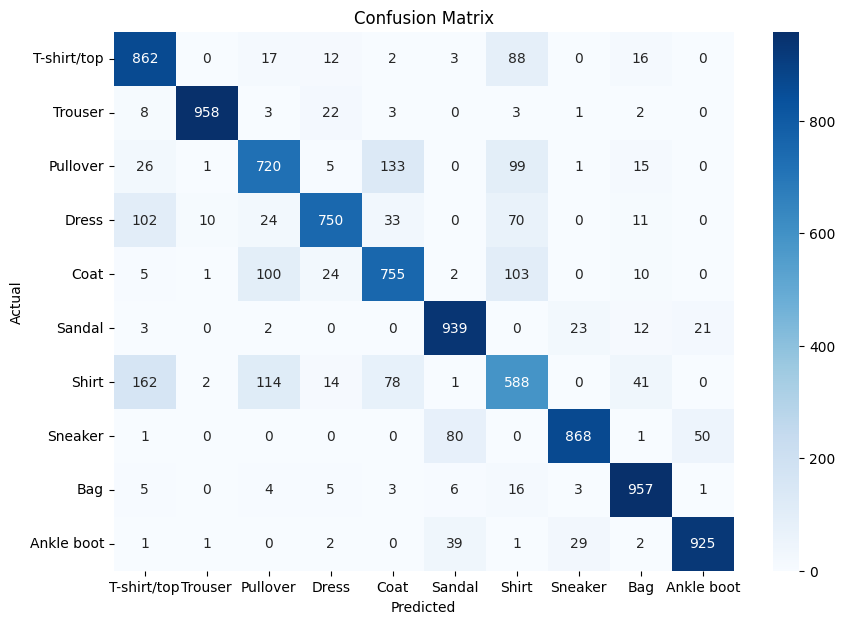

In [285]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_svm_linear)

# Display the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
                         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'],
            yticklabels=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
                         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Comparison

In [286]:
metrics_data = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "Logistic Regression": [logistic_accuracy, logistic_precision, logistic_recall, logistic_f1],
    "SVM (Linear)": [svm_linear_accuracy, svm_linear_precision, svm_linear_recall, svm_linear_f1],
    "SVM (RBF)": [svm_rbf_accuracy, svm_rbf_precision, svm_rbf_recall, svm_rbf_f1]    
}

metrics_df = pd.DataFrame(metrics_data)
metrics_df.head().style.hide()

**Nhận xét nhanh:**

*  Mô hình cho kết quả tốt nhất dựa trên cả 4 metric là SVM (RBF kernel), tiếp sau đó là Logistic Regression và SVM (Linear kernel).
*  Mô hình Logistic Regression tuy tốt hơn SVM (Linear kernel) nhưng chỉ hơn khoảng 0.01 điểm ở cả 4 metric. Trong khi đó, mô hình SVM (RBF kernel) lại vượt trội hơn hẳn mô hình Logistic Regression (đứng hạng 2) khi hơn khoảng 0.04 điểm ở cả 4 metric.

⇒ Kết quả trên là hợp lý và đúng với lý thuyết vì:
*  Cả 2 mô hình Logistic Regression và SVM (Linear kernel) đều phân loại một cách tuyến tính trong khi bộ dữ liệu là hình ảnh - có tương quan phi tuyến giữa các điểm ảnh - dẫn đến sự không phù hợp giữa phương pháp và dữ liệu của bài toán, nên rõ ràng dù có chênh lệch nhỏ nhưng cả 2 đều có kết quả tụt lại hẳn so với mô hình SVM (RBF kernel).
*  Ngược lại, mô hình SVM (RBF kernel) có khả năng tính toán các high-dimensional relationships (tạm dịch là tương quan có số chiều lớn) - một phương pháp phù hợp với dữ liệu có tương quan phi tuyến như FashionMNist - điều này đem lại sự tương thích cao giữa phương pháp và dữ liệu bài toán, nên cũng dễ hiểu khi mô hình SVM (RBF kernel) cho kết quả cao nhất và cách xa so với 2 phương pháp còn lại.

In [287]:
runtime_data = {
    "Runtime": ["Training", "Prediction"],
    "Logistic Regression": [logistic_train_time, logistic_pred_time],
    "SVM (Linear)": [svm_linear_train_time, svm_linear_pred_time],
    "SVM (RBF)": [svm_rbf_train_time, svm_rbf_pred_time]    
}

runtime_df = pd.DataFrame(runtime_data)
runtime_df.head().style.hide()

## 3. Curse of Dimensionality & Dimensionality Reduction

Khi số chiều (đặc trưng) tăng lên, thể tích của không gian đặc trưng tăng lên theo hàm mũ. Điều này dẫn đến một số vấn đề (hay còn gọi là Curse of Dimensionality) như:
*  Dữ liệu thưa thớt
*  Các phép đo khoảng cách mang ít thông tin hơn
*  Độ phức tạp tính toán tăng lên
*  Nguy cơ overfitting

⇒ Curse of dimensionality ảnh hưởng đến nhiều loại mô hình Machine Learning theo các cách khác nhau, đặc biệt là các mô hình phụ thuộc vào tính toán khoảng cách hoặc cần một lượng lớn dữ liệu huấn luyện để tổng quát hóa hiệu quả.

### PCA

Trực quan hóa bộ dữ liệu sau khi PCA.

In [288]:
pca_df = pd.DataFrame(X_train)
pca_df['label'] = pd.DataFrame(y_train)

In [289]:
pca_result = PCA(n_components=3, random_state=0).fit_transform(pca_df.drop(['label'], axis=1))

In [290]:
pca_df['class_name'] = pca_df['label'].map(lambda x: class_names[x])
pca_df.head()

0    1    2    3    4         5  ...  780  781  782  783  label   class_name
0  0.0  0.0  0.0  0.0  0.0  0.000000  ...  0.0  0.0  0.0  0.0      9   Ankle boot
1  0.0  0.0  0.0  0.0  0.0  0.004348  ...  0.0  0.0  0.0  0.0      0  T-shirt/top
2  0.0  0.0  0.0  0.0  0.0  0.000000  ...  0.0  0.0  0.0  0.0      0  T-shirt/top
3  0.0  0.0  0.0  0.0  0.0  0.000000  ...  0.0  0.0  0.0  0.0      3        Dress
4  0.0  0.0  0.0  0.0  0.0  0.000000  ...  0.0  0.0  0.0  0.0      0  T-shirt/top

[5 rows x 786 columns]

<Axes: >

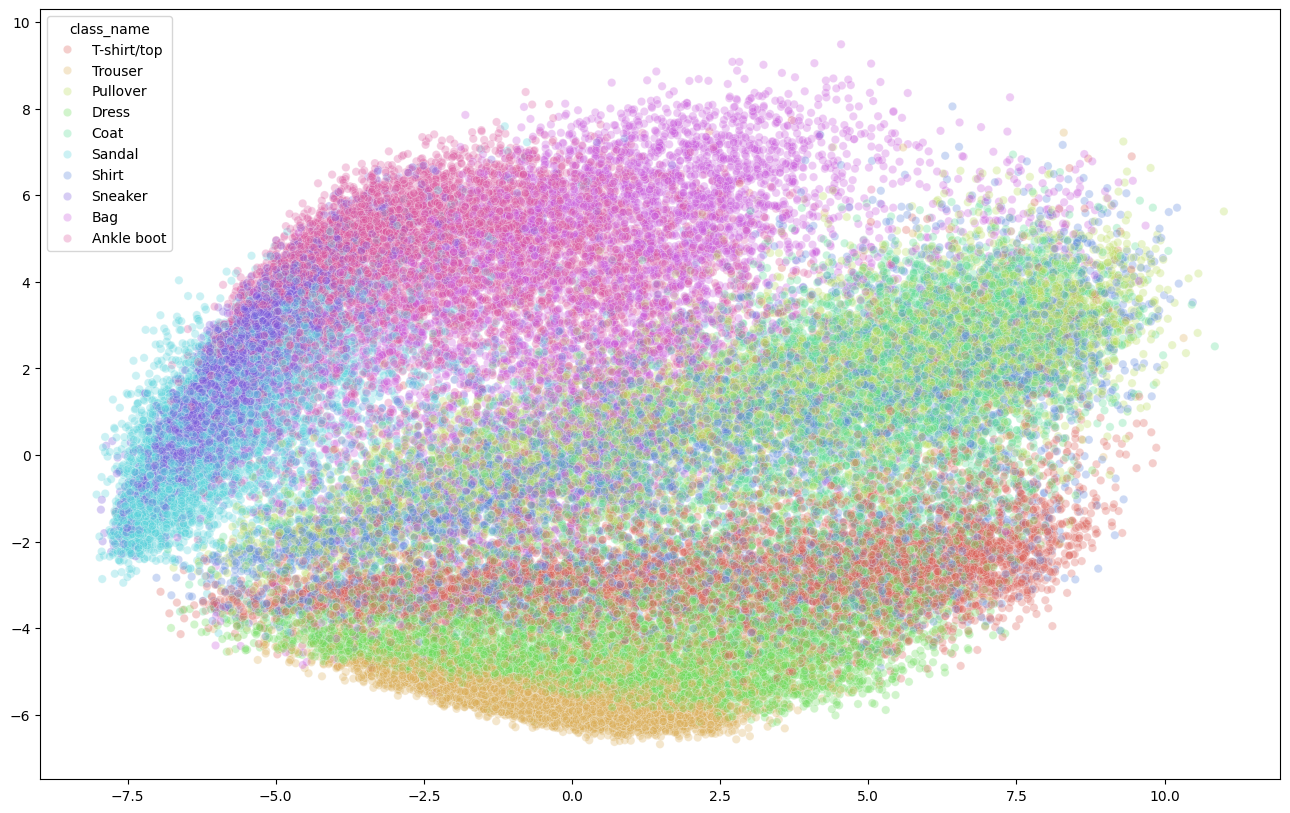

In [291]:
plt.figure(figsize=(16,10))

sns.scatterplot(
    x=pca_result[:,0], y=pca_result[:,1],
    hue = "class_name",
    hue_order = class_names,
    palette=sns.color_palette("hls", 10),
    data=pca_df,
    legend="full",
    alpha=0.3
)

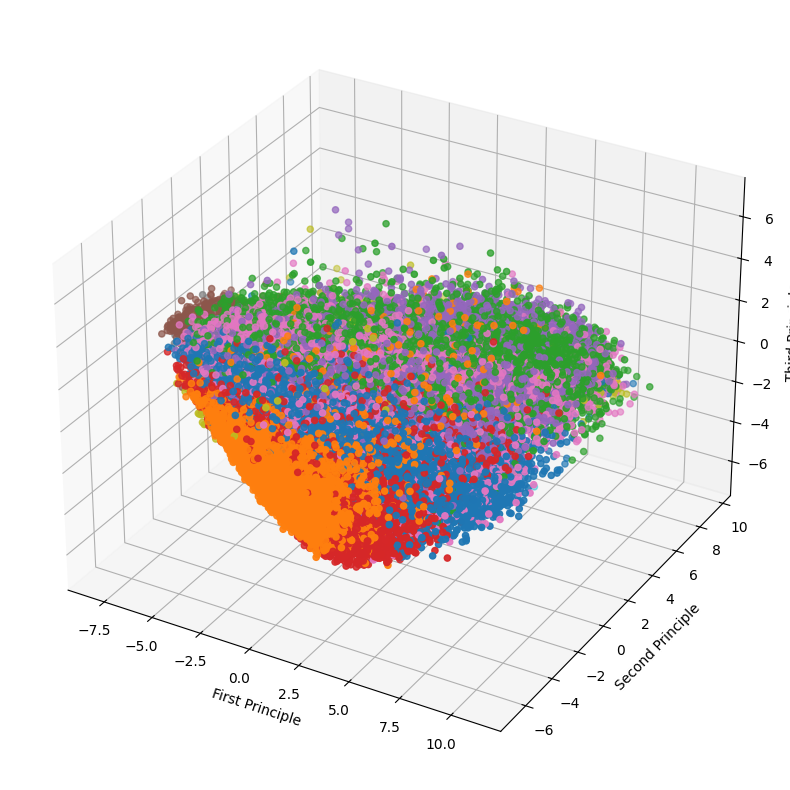

In [292]:
graph = plt.figure(figsize=(16,10)).add_subplot(projection='3d')
graph.scatter(
    xs=pca_result[:,0], 
    ys=pca_result[:,1], 
    zs=pca_result[:,2], 
    c=pca_df["label"], 
    cmap='tab10'
)
graph.set_xlabel('First Principle')
graph.set_ylabel('Second Principle')
graph.set_zlabel('Third Principle')
plt.show()

**Nhận xét nhanh:**

Từ hình trực quan hóa ở trên, ta có thể thấy với 2 và 3 thành phần chính thì PCA chưa thể phân tách được các class (ở trường hợp 2 thành phần chính tuy có vẻ phân tách được một ít nhưng vẫn còn chưa đủ tách biệt). Điều này cũng là dễ hiểu vì PCA vốn sẽ lựa chọn các thành phần chính sao cho phương sai khi chiếu lên chúng là lớn nhất để giữ lại được nhiều thông tin nhất, chứ không có chủ đích là muốn phân tách các class.

⇒ PCA có thể giúp giảm chiều dữ liệu, đơn giản hóa việc tính toán cho các mô hình mà vẫn giữ được lượng thông tin lớn. Tuy nhiên, nếu mục đích của ta là phân loại các class thì có lẽ PCA chưa phải sự lựa chọn tốt nhất trong các phương pháp giảm chiều dữ liệu.

Đánh giá độ lưu trữ thông tin của các thành phần chính sau khi PCA.

In [293]:
pca = PCA(n_components = 784)
pca_784 = pca.fit_transform(X_train.copy())
var_ratios = np.cumsum(pca.explained_variance_ratio_)

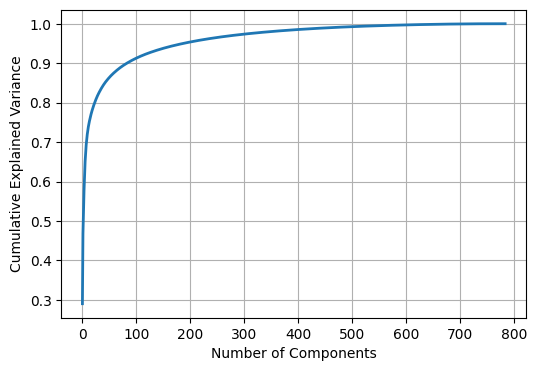

In [294]:
# Plot the PCA spectrum
plt.figure(figsize=(6, 4))
plt.plot(var_ratios, linewidth=2)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid()
plt.show()

**Nhận xét nhanh:**

Ta thấy nếu giữ lại khoảng 80 thành phần chính đầu tiên thì ta đã giữ được 90% lượng thông tin ban đầu và nếu giữ lại 200 thành phần chính đầu tiên thì ta đã giữ được tận 95% lượng thông tin ban đầu.

⇒ Ta sẽ giữ lại 200 thành phần chính đầu tiên.

In [295]:
pca = PCA(n_components=200, random_state=0).fit(X_train)
X_train_pca = pca.transform(X_train.copy())
X_test_pca = pca.transform(X_test.copy())

#### Re-train lại các model ở trên

Logistic Regression

In [296]:
start_time = time.time()

logistic_model_pca = LogisticRegression(max_iter=100, solver='lbfgs', multi_class='multinomial', verbose=1, random_state=0)
logistic_model_pca.fit(X_train_pca, y_train)

end_time = time.time()
logistic_pca_train_time = end_time - start_time
print("Runtime: {:.2f} seconds".format(end_time - start_time))

c:\Users\admin\anaconda3\envs\gan\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Runtime: 4.07 seconds


c:\Users\admin\anaconda3\envs\gan\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [297]:
y_pred_logistic_pca = logistic_model_pca.predict(X_test_pca)

In [298]:
# Evaluate the model
logistic_pca_accuracy = accuracy_score(y_test, y_pred_logistic_pca)
logistic_pca_precision = precision_score(y_test, y_pred_logistic_pca, average='weighted')
logistic_pca_recall = recall_score(y_test, y_pred_logistic_pca, average='weighted')
logistic_pca_f1 = f1_score(y_test, y_pred_logistic_pca, average='weighted')

# Print key metrics
print(f"Accuracy: {logistic_pca_accuracy:.4f}")
print(f"Precision: {logistic_pca_precision:.4f}")
print(f"Recall: {logistic_pca_recall:.4f}")
print(f"F1 Score: {logistic_pca_f1:.4f}")

Accuracy: 0.8428
Precision: 0.8414
Recall: 0.8428
F1 Score: 0.8419


In [299]:
print(classification_report(y_test, y_pred_logistic_pca))

              precision    recall  f1-score   support

           0       0.80      0.81      0.80      1000
           1       0.98      0.96      0.97      1000
           2       0.72      0.73      0.73      1000
           3       0.83      0.87      0.85      1000
           4       0.74      0.75      0.74      1000
           5       0.94      0.92      0.93      1000
           6       0.62      0.56      0.59      1000
           7       0.90      0.94      0.92      1000
           8       0.93      0.94      0.94      1000
           9       0.95      0.94      0.94      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



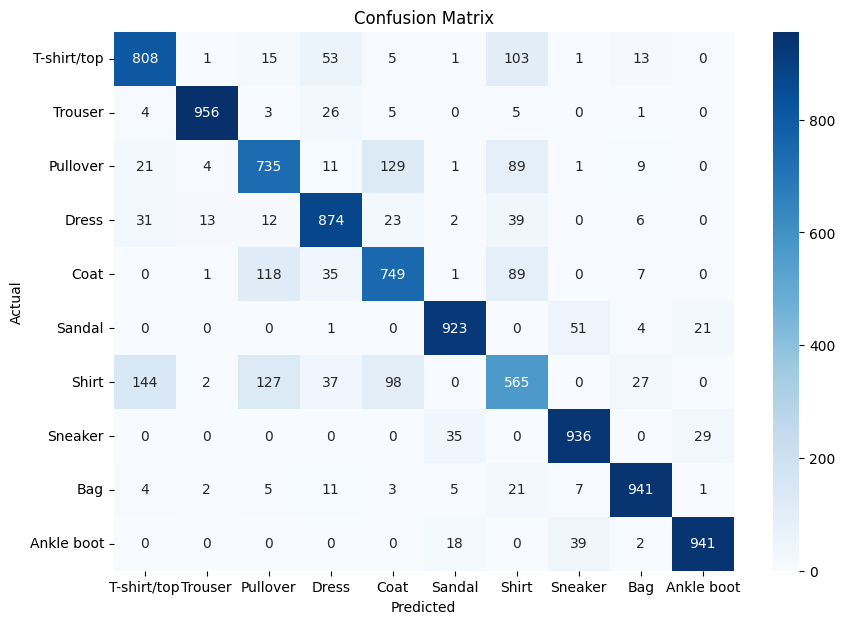

In [300]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_logistic_pca)

# Display the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
                         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'],
            yticklabels=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
                         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

SVM - RBF Kernel

In [301]:
start_time = time.time()

svm_rbf_model_pca = SVC(kernel='rbf', random_state=0)
svm_rbf_model_pca.fit(X_train_pca, y_train)

end_time = time.time()
svm_rbf_pca_train_time = end_time - start_time
print("Runtime: {:.2f} seconds".format(end_time - start_time))

Runtime: 117.89 seconds


In [302]:
y_pred_svm_rbf_pca = svm_rbf_model_pca.predict(X_test_pca)

In [303]:
# Evaluate the model
svm_rbf_pca_accuracy = accuracy_score(y_test, y_pred_svm_rbf_pca)
svm_rbf_pca_precision = precision_score(y_test, y_pred_svm_rbf_pca, average='weighted')
svm_rbf_pca_recall = recall_score(y_test, y_pred_svm_rbf_pca, average='weighted')
svm_rbf_pca_f1 = f1_score(y_test, y_pred_svm_rbf_pca, average='weighted')

# Print key metrics
print(f"Accuracy: {svm_rbf_pca_accuracy:.4f}")
print(f"Precision: {svm_rbf_pca_precision:.4f}")
print(f"Recall: {svm_rbf_pca_recall:.4f}")
print(f"F1 Score: {svm_rbf_pca_f1:.4f}")

Accuracy: 0.8855
Precision: 0.8851
Recall: 0.8855
F1 Score: 0.8851


In [304]:
print(classification_report(y_test, y_pred_svm_rbf_pca))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84      1000
           1       0.99      0.96      0.98      1000
           2       0.80      0.82      0.81      1000
           3       0.87      0.89      0.88      1000
           4       0.81      0.82      0.82      1000
           5       0.97      0.95      0.96      1000
           6       0.71      0.66      0.69      1000
           7       0.93      0.96      0.95      1000
           8       0.97      0.97      0.97      1000
           9       0.96      0.95      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



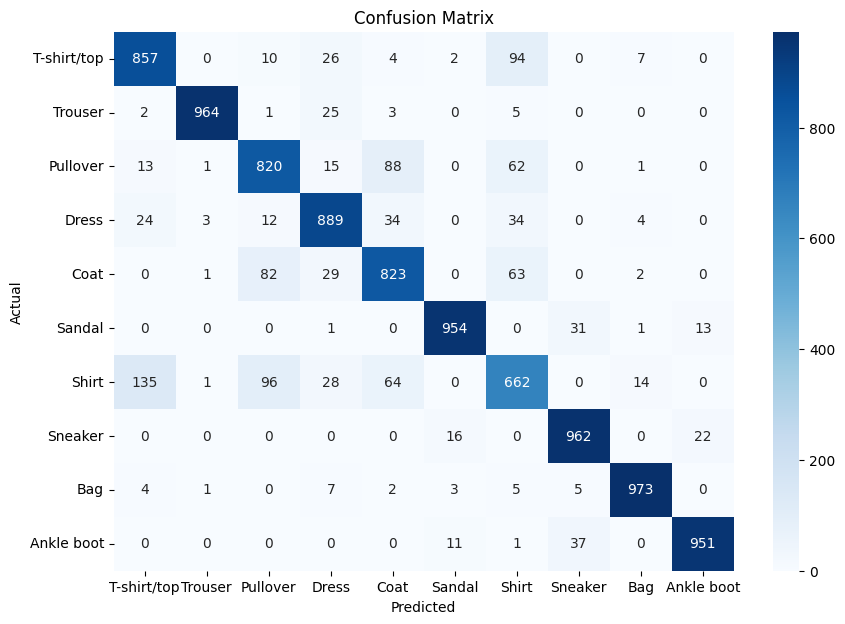

In [305]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_svm_rbf_pca)

# Display the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
                         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'],
            yticklabels=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
                         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

SVM - Linear Kernel

In [306]:
start_time = time.time()

svm_linear_model_pca = SGDClassifier(loss='hinge', random_state=0)
svm_linear_model_pca.fit(X_train_pca, y_train)

end_time = time.time()
svm_linear_pca_train_time = end_time - start_time
print("Runtime: {:.2f} seconds".format(end_time - start_time))

Runtime: 8.83 seconds


In [307]:
y_pred_svm_linear_pca = svm_linear_model_pca.predict(X_test_pca)

In [308]:
# Evaluate the model
svm_linear_pca_accuracy = accuracy_score(y_test, y_pred_svm_linear_pca)
svm_linear_pca_precision = precision_score(y_test, y_pred_svm_linear_pca, average='weighted')
svm_linear_pca_recall = recall_score(y_test, y_pred_svm_linear_pca, average='weighted')
svm_linear_pca_f1 = f1_score(y_test, y_pred_svm_linear_pca, average='weighted')

# Print key metrics
print(f"Accuracy: {svm_linear_pca_accuracy:.4f}")
print(f"Precision: {svm_linear_pca_precision:.4f}")
print(f"Recall: {svm_linear_pca_recall:.4f}")
print(f"F1 Score: {svm_linear_pca_f1:.4f}")

Accuracy: 0.8338
Precision: 0.8326
Recall: 0.8338
F1 Score: 0.8306


In [309]:
print(classification_report(y_test, y_pred_svm_linear_pca))

              precision    recall  f1-score   support

           0       0.76      0.82      0.79      1000
           1       0.98      0.95      0.96      1000
           2       0.69      0.75      0.72      1000
           3       0.81      0.86      0.84      1000
           4       0.71      0.80      0.75      1000
           5       0.95      0.90      0.93      1000
           6       0.65      0.45      0.53      1000
           7       0.92      0.92      0.92      1000
           8       0.90      0.95      0.93      1000
           9       0.95      0.93      0.94      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



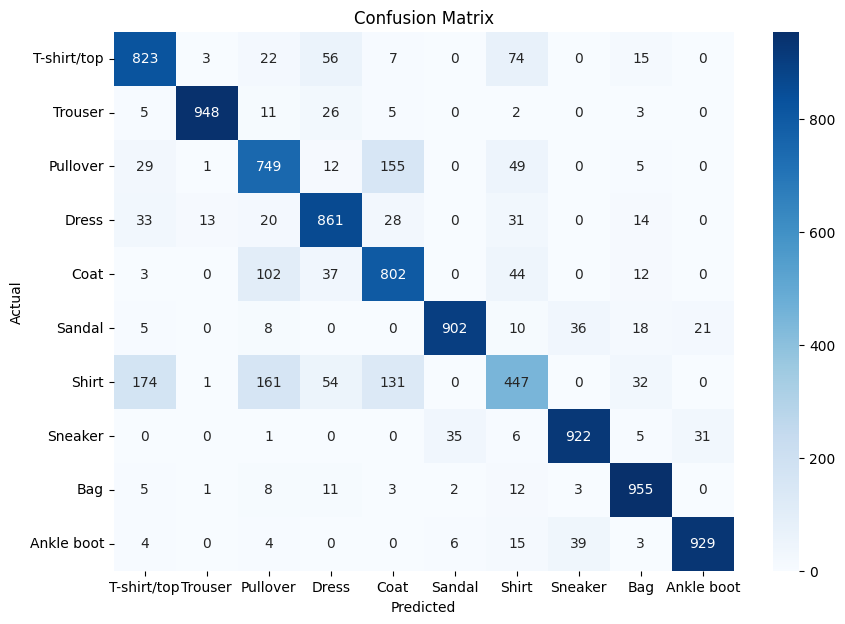

In [310]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_svm_linear_pca)

# Display the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
                         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'],
            yticklabels=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
                         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### LDA

Trực quan hóa bộ dữ liệu sau khi LDA.

In [311]:
lda_df = pd.DataFrame(X_train)
lda_df['label'] = pd.DataFrame(y_train)
lda_df['class_name'] = lda_df['label'].map(lambda x: class_names[x])
lda_df.head()

0    1    2    3    4         5  ...  780  781  782  783  label   class_name
0  0.0  0.0  0.0  0.0  0.0  0.000000  ...  0.0  0.0  0.0  0.0      9   Ankle boot
1  0.0  0.0  0.0  0.0  0.0  0.004348  ...  0.0  0.0  0.0  0.0      0  T-shirt/top
2  0.0  0.0  0.0  0.0  0.0  0.000000  ...  0.0  0.0  0.0  0.0      0  T-shirt/top
3  0.0  0.0  0.0  0.0  0.0  0.000000  ...  0.0  0.0  0.0  0.0      3        Dress
4  0.0  0.0  0.0  0.0  0.0  0.000000  ...  0.0  0.0  0.0  0.0      0  T-shirt/top

[5 rows x 786 columns]

In [312]:
lda_result = LinearDiscriminantAnalysis(n_components=3).fit_transform(X_train, y_train)

<Axes: >

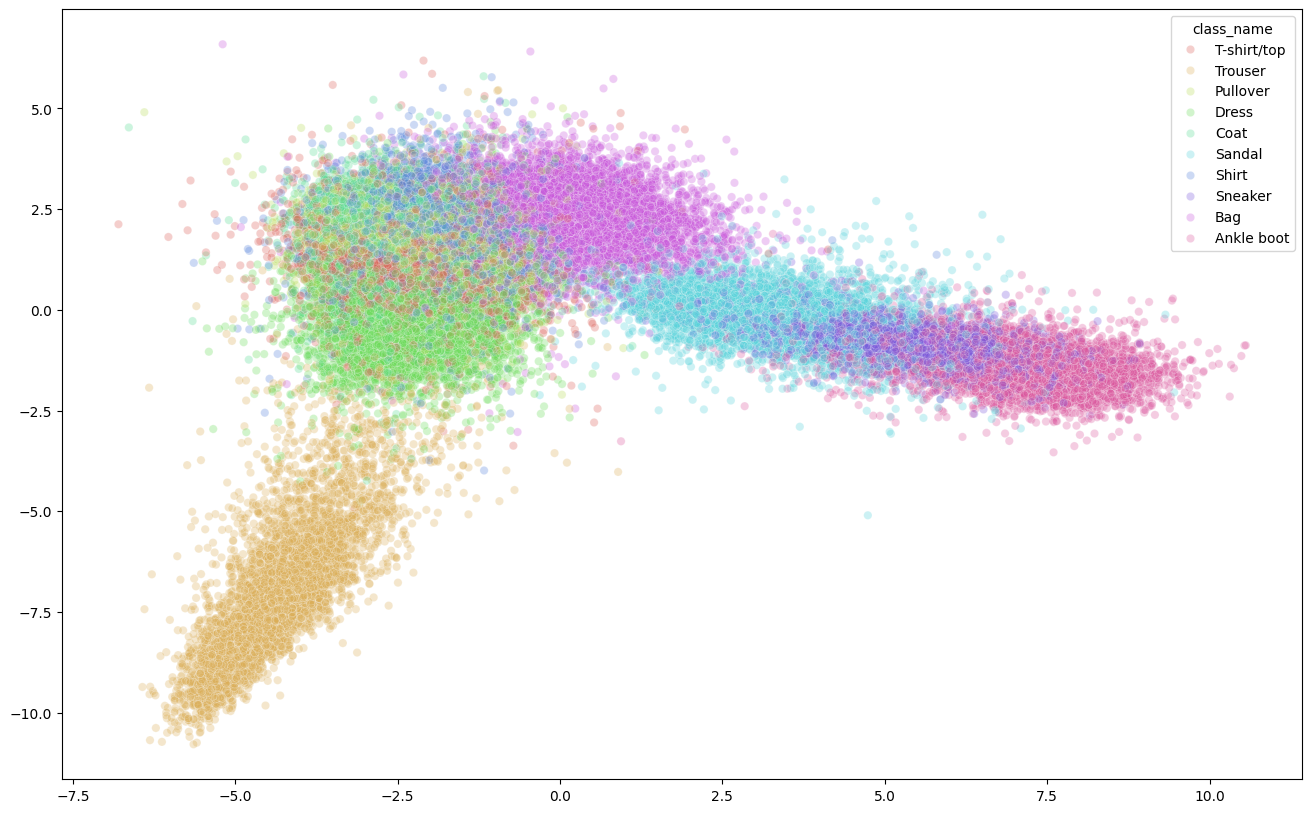

In [313]:
plt.figure(figsize=(16,10))

sns.scatterplot(
    x=lda_result[:,0], y=lda_result[:,1],
    hue = "class_name",
    hue_order = class_names,
    palette=sns.color_palette("hls", 10),
    data=lda_df,
    legend="full",
    alpha=0.3
)

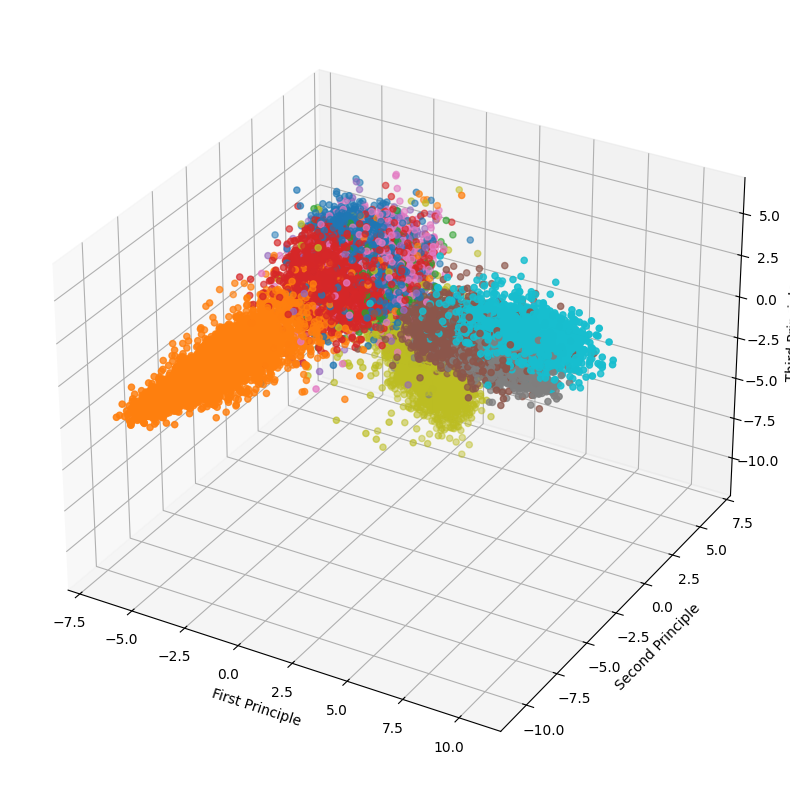

In [314]:
graph = plt.figure(figsize=(16,10)).add_subplot(projection='3d')
graph.scatter(
    xs=lda_result[:,0], 
    ys=lda_result[:,1], 
    zs=lda_result[:,2], 
    c=lda_df["label"], 
    cmap='tab10'
)
graph.set_xlabel('First Principle')
graph.set_ylabel('Second Principle')
graph.set_zlabel('Third Principle')
plt.show()

**Nhận xét nhanh:**

Từ hình vẽ 2 và 3 chiều sau khi LDA, ta có thể thấy ngay là hầu hết các class được phân tách rất tốt thậm chí có thể phân biệt được bằng mắt thường. Tuy nhiên, vẫn còn một vài class chưa phân tách được rõ ràng lắm, điều này cũng dễ hiểu vì có các class có hình thù khá giống nhau như 'Dress', 'Pullover', 'Shirt'... Kết quả này có được là vì LDA cũng tương tự như PCA nhưng thay vì ưu tiên giữ lại phương sai lớn nhất thì LDA ưu tiên tối đa hóa khả năng phân tách (tuyến tính) giữa các class trong khi giảm nhỏ khoảng cách giữa các điểm trong cùng một class.

⇒ LDA vừa có thể giúp giảm chiều dữ liệu, vừa giúp bộ dữ liệu trở nên dễ phân loại hơn. Quan sát trên cho ta kỳ vọng kết quả của các mô hình khi sử dụng bộ dữ liệu sau khi đã LDA có thể cho ra kết quả tốt hơn so với PCA.

In [315]:
lda = LinearDiscriminantAnalysis().fit(X_train, y_train)
X_train_lda = lda.transform(X_train.copy())
X_test_lda = lda.transform(X_test.copy())

#### Re-train lại các model ở trên

Logistic Regression

In [316]:
start_time = time.time()

logistic_model_lda = LogisticRegression(verbose=1, random_state=0)
logistic_model_lda.fit(X_train_lda, y_train)

end_time = time.time()
logistic_lda_train_time = end_time - start_time
print("Runtime: {:.2f} seconds".format(end_time - start_time))

Runtime: 1.47 seconds


c:\Users\admin\anaconda3\envs\gan\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [317]:
y_pred_logistic_lda = logistic_model_lda.predict(X_test_lda)

In [318]:
# Evaluate the model
logistic_lda_accuracy = accuracy_score(y_test, y_pred_logistic_lda)
logistic_lda_precision = precision_score(y_test, y_pred_logistic_lda, average='weighted')
logistic_lda_recall = recall_score(y_test, y_pred_logistic_lda, average='weighted')
logistic_lda_f1 = f1_score(y_test, y_pred_logistic_lda, average='weighted')

# Print key metrics
print(f"Accuracy: {logistic_lda_accuracy:.4f}")
print(f"Precision: {logistic_lda_precision:.4f}")
print(f"Recall: {logistic_lda_recall:.4f}")
print(f"F1 Score: {logistic_lda_f1:.4f}")

Accuracy: 0.8241
Precision: 0.8229
Recall: 0.8241
F1 Score: 0.8232


In [319]:
print(classification_report(y_test, y_pred_logistic_lda))

              precision    recall  f1-score   support

           0       0.79      0.80      0.79      1000
           1       0.98      0.95      0.96      1000
           2       0.70      0.70      0.70      1000
           3       0.82      0.85      0.83      1000
           4       0.71      0.74      0.72      1000
           5       0.91      0.88      0.90      1000
           6       0.60      0.55      0.57      1000
           7       0.89      0.91      0.90      1000
           8       0.93      0.94      0.93      1000
           9       0.92      0.92      0.92      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



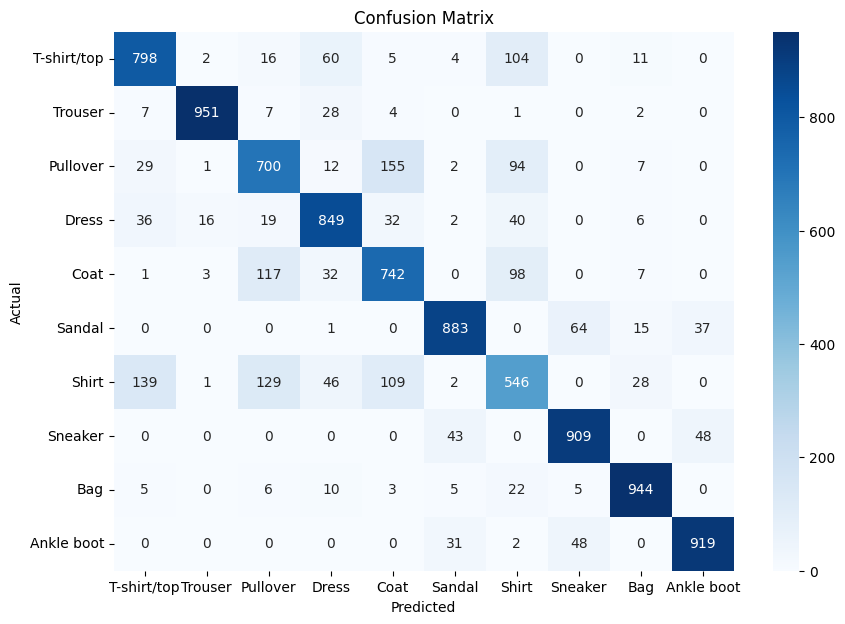

In [320]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_logistic_lda)

# Display the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
                         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'],
            yticklabels=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
                         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

SVM - RBF Kernel

In [321]:
start_time = time.time()

svm_rbf_model_lda = SVC(kernel='rbf', random_state=0)
svm_rbf_model_lda.fit(X_train_lda, y_train)

end_time = time.time()
svm_rbf_lda_train_time = end_time - start_time
print("Runtime: {:.2f} seconds".format(end_time - start_time))

Runtime: 12.43 seconds


In [322]:
y_pred_svm_rbf_lda = svm_rbf_model_lda.predict(X_test_lda)

In [323]:
# Evaluate the model
svm_rbf_lda_accuracy = accuracy_score(y_test, y_pred_svm_rbf_lda)
svm_rbf_lda_precision = precision_score(y_test, y_pred_svm_rbf_lda, average='weighted')
svm_rbf_lda_recall = recall_score(y_test, y_pred_svm_rbf_lda, average='weighted')
svm_rbf_lda_f1 = f1_score(y_test, y_pred_svm_rbf_lda, average='weighted')

# Print key metrics
print(f"Accuracy: {svm_rbf_lda_accuracy:.4f}")
print(f"Precision: {svm_rbf_lda_precision:.4f}")
print(f"Recall: {svm_rbf_lda_recall:.4f}")
print(f"F1 Score: {svm_rbf_lda_f1:.4f}")

Accuracy: 0.8341
Precision: 0.8326
Recall: 0.8341
F1 Score: 0.8322


In [324]:
print(classification_report(y_test, y_pred_svm_rbf_lda))

              precision    recall  f1-score   support

           0       0.78      0.82      0.80      1000
           1       0.99      0.95      0.97      1000
           2       0.73      0.71      0.72      1000
           3       0.83      0.87      0.85      1000
           4       0.70      0.79      0.74      1000
           5       0.93      0.89      0.91      1000
           6       0.64      0.51      0.57      1000
           7       0.88      0.93      0.90      1000
           8       0.92      0.95      0.93      1000
           9       0.93      0.91      0.92      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



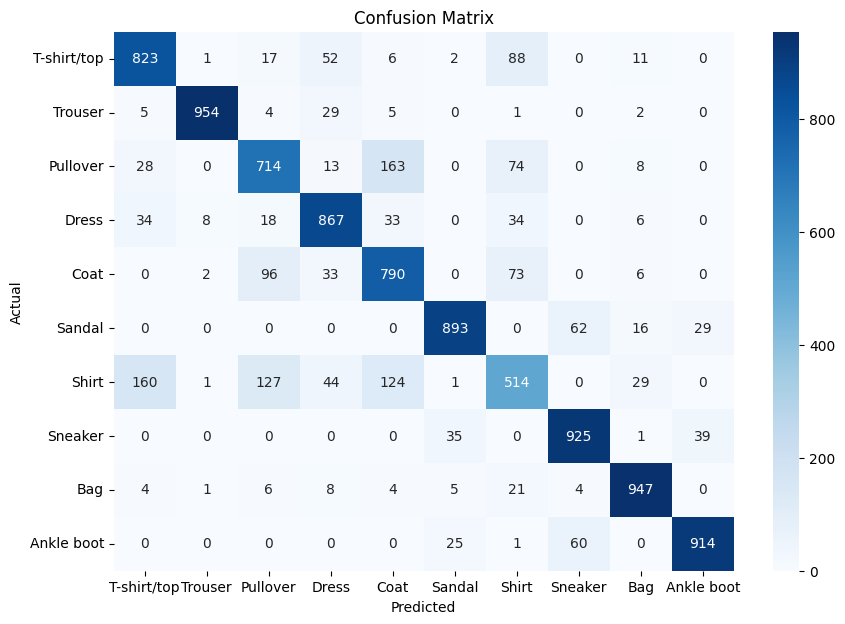

In [325]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_svm_rbf_lda)

# Display the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
                         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'],
            yticklabels=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
                         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

SVM - Linear Kernel

In [326]:
start_time = time.time()

svm_linear_model_lda = SGDClassifier(loss='hinge', random_state=0)
svm_linear_model_lda.fit(X_train_lda, y_train)

end_time = time.time()
svm_linear_lda_train_time = end_time - start_time
print("Runtime: {:.2f} seconds".format(end_time - start_time))

Runtime: 0.45 seconds


In [327]:
y_pred_svm_linear_lda = svm_linear_model_lda.predict(X_test_lda)

In [328]:
# Evaluate the model
svm_linear_lda_accuracy = accuracy_score(y_test, y_pred_svm_linear_lda)
svm_linear_lda_precision = precision_score(y_test, y_pred_svm_linear_lda, average='weighted')
svm_linear_lda_recall = recall_score(y_test, y_pred_svm_linear_lda, average='weighted')
svm_linear_lda_f1 = f1_score(y_test, y_pred_svm_linear_lda, average='weighted')

# Print key metrics
print(f"Accuracy: {svm_linear_lda_accuracy:.4f}")
print(f"Precision: {svm_linear_lda_precision:.4f}")
print(f"Recall: {svm_linear_lda_recall:.4f}")
print(f"F1 Score: {svm_linear_lda_f1:.4f}")

Accuracy: 0.8155
Precision: 0.8135
Recall: 0.8155
F1 Score: 0.8119


In [329]:
print(classification_report(y_test, y_pred_svm_linear_lda))

              precision    recall  f1-score   support

           0       0.72      0.83      0.77      1000
           1       0.97      0.95      0.96      1000
           2       0.77      0.62      0.68      1000
           3       0.81      0.85      0.83      1000
           4       0.69      0.79      0.74      1000
           5       0.90      0.86      0.88      1000
           6       0.62      0.49      0.55      1000
           7       0.89      0.88      0.88      1000
           8       0.88      0.95      0.91      1000
           9       0.89      0.94      0.91      1000

    accuracy                           0.82     10000
   macro avg       0.81      0.82      0.81     10000
weighted avg       0.81      0.82      0.81     10000



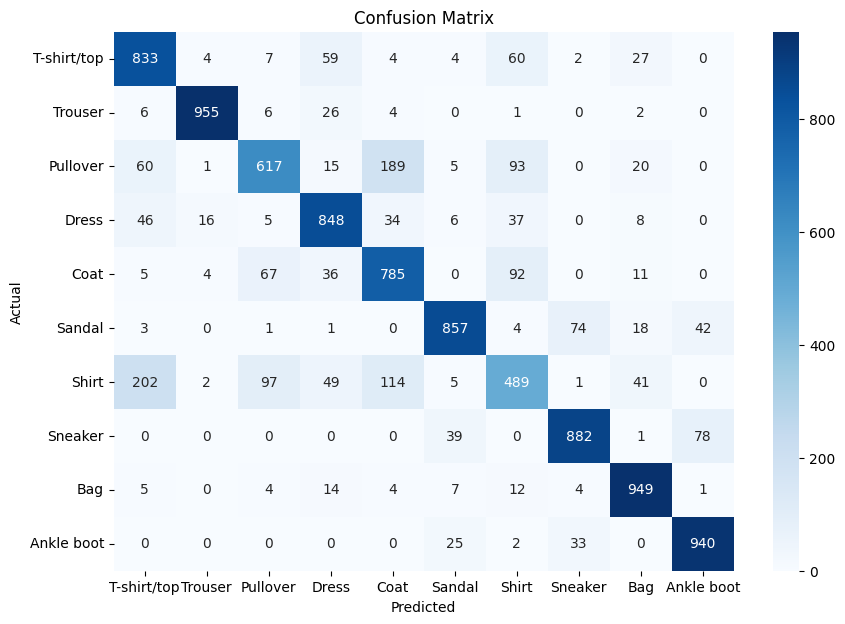

In [330]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_svm_linear_lda)

# Display the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
                         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'],
            yticklabels=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
                         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Nhận xét nhanh:**

Ta thấy cả 3 mô hình đều cho ra kết quả tệ hơn PCA ở cả 4 metric, điều này là ngược lại với những gì ta kỳ vọng.

⇒ Nguyên nhân dẫn tới kết quả này có lẽ đến từ:

*  Các class có hình thù gần giống nhau như 'Dress', 'Pullover', 'Shirt'... có phân phối gần nhau và LDA đã không phân tách được chúng tốt và vì hiệu ứng các class khác nhau thì càng được phân tách, các class giống nhau thì gần hơn nên vô tình đã đẩy các class trên lại gần nhau hơn. Điều này làm khó khăn hơn trong việc phân loại chúng. Bằng chứng là trong Confusion Matrix của 3 model, ta thấy giá trị dự doán đúng của class 'Shirt' thấp hơn hẳn các mô hình không giảm chiều hoặc giảm chiều bằng PCA.
*  Các class vốn đã tách biệt tốt trong bộ dữ liệu và cho kết quả tốt trong các mô hình không giảm chiều thì sau khi LDA (giúp chúng tách biệt hơn nữa) sẽ không giúp cải thiện kết quả quá nhiều.

### Comparison

In [331]:
runtime_data = {
    "Runtime - Training": ["PCA", "LDA"],
    "Logistic Regression": [logistic_pca_train_time, logistic_lda_train_time],
    "SVM (Linear)": [svm_rbf_pca_train_time, svm_rbf_lda_train_time],
    "SVM (RBF)": [svm_linear_pca_train_time, svm_linear_lda_train_time]    
}

runtime_df = pd.DataFrame(runtime_data)
runtime_df.head().style.hide()

**Nhận xét nhanh:**

Thời gian train sau khi giảm chiều đã giảm đáng kể. Điều này là hợp lý vì số lượng feature đã giảm rất nhiều nên quá trình tính toán với mỗi sample cũng giảm tỉ lệ thuận với lượng feature loại bỏ. Tuy nhiên, dễ thấy là ta đã bị mất mát thông tin so với bộ dữ liệu ban đầu, điều này dẫn tới mô hình sẽ có ít thông tin hơn để học. Ta có thể cân nhắc đánh đổi giữa tài nguyên tính toán, điểm metric của mô hình và lượng thông tin mô hình nhận được. (Ở đây mô hình nhận được ít thông tin hơn không có nghĩa là điều xấu trong mọi tình huống, vì có thể nó sẽ giúp bỏ bớt các feature không có nhiều ảnh hưởng, giảm độ phức tạp mô hình và có thể giúp mô hình tổng quát hóa được tốt hơn. Cụ thể là các mô hình SVM sử dụng PCA, ta sẽ phân tích kĩ hơn sau).


## 4. Model Evaluation & Comparison

### So sánh các model

In [332]:
metrics_data = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "Logistic Regression": [logistic_accuracy, logistic_precision, logistic_recall, logistic_f1],
    "Logistic Regression - PCA": [logistic_pca_accuracy, logistic_pca_precision, logistic_pca_recall, logistic_pca_f1],
    "Logistic Regression - LDA": [logistic_accuracy, logistic_precision, logistic_recall, logistic_f1]
}

logistic_metrics_df = pd.DataFrame(metrics_data)
logistic_metrics_df.head().style.hide()

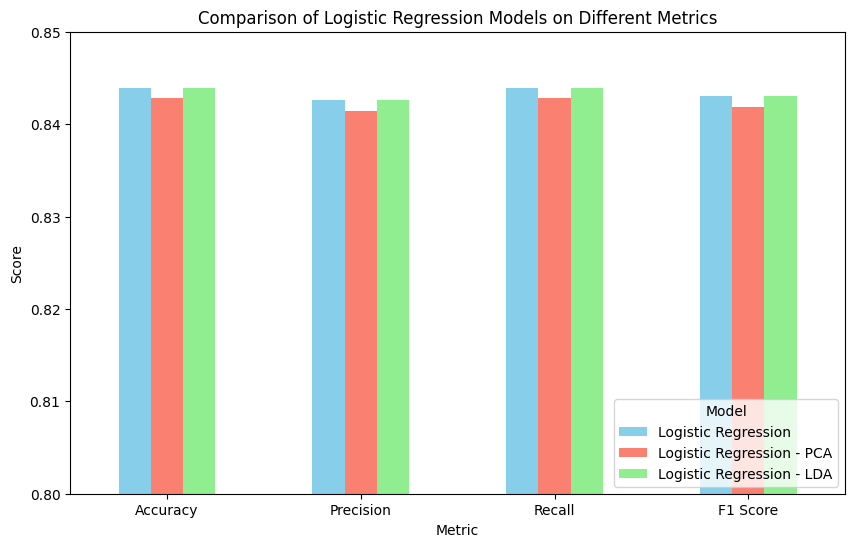

In [333]:
fig, ax = plt.subplots(figsize=(10, 6))
logistic_metrics_df.set_index("Metric").plot(kind="bar", ax=ax, color=["skyblue", "salmon", "lightgreen"])
ax.set_title("Comparison of Logistic Regression Models on Different Metrics")
ax.set_ylabel("Score")
ax.set_xlabel("Metric")
plt.ylim(0.8, 0.85)
plt.xticks(rotation=0)
plt.legend(title="Model", loc='lower right')
plt.show()

In [334]:
metrics_data = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "SVM (RBF)": [svm_rbf_accuracy, svm_rbf_precision, svm_rbf_recall, svm_rbf_f1], 
    "SVM (RBF) - PCA": [svm_rbf_pca_accuracy, svm_rbf_pca_precision, svm_rbf_pca_recall, svm_rbf_pca_f1],
    "SVM (RBF) - LDA": [svm_rbf_lda_accuracy, svm_rbf_lda_precision, svm_rbf_lda_recall, svm_rbf_lda_f1]
}

svm_rbf_metrics_df = pd.DataFrame(metrics_data)
svm_rbf_metrics_df.head().style.hide()

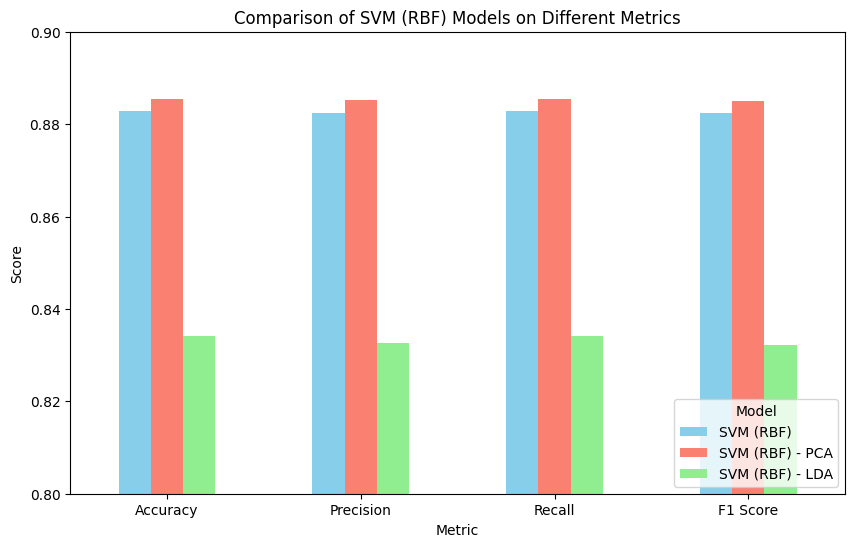

In [335]:
fig, ax = plt.subplots(figsize=(10, 6))
svm_rbf_metrics_df.set_index("Metric").plot(kind="bar", ax=ax, color=["skyblue", "salmon", "lightgreen"])
ax.set_title("Comparison of SVM (RBF) Models on Different Metrics")
ax.set_ylabel("Score")
ax.set_xlabel("Metric")
plt.ylim(0.8, 0.9)
plt.xticks(rotation=0)
plt.legend(title="Model", loc='lower right')
plt.show()

In [336]:
metrics_data = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "SVM (Linear)": [svm_linear_accuracy, svm_linear_precision, svm_linear_recall, svm_linear_f1],
    "SVM (Linear) - PCA": [svm_linear_pca_accuracy, svm_linear_pca_precision, svm_linear_pca_recall, svm_linear_pca_f1],
    "SVM (Linear) - LDA": [svm_linear_lda_accuracy, svm_linear_lda_precision, svm_linear_lda_recall, svm_linear_lda_f1]
}

svm_linear_metrics_df = pd.DataFrame(metrics_data)
svm_linear_metrics_df.head().style.hide()

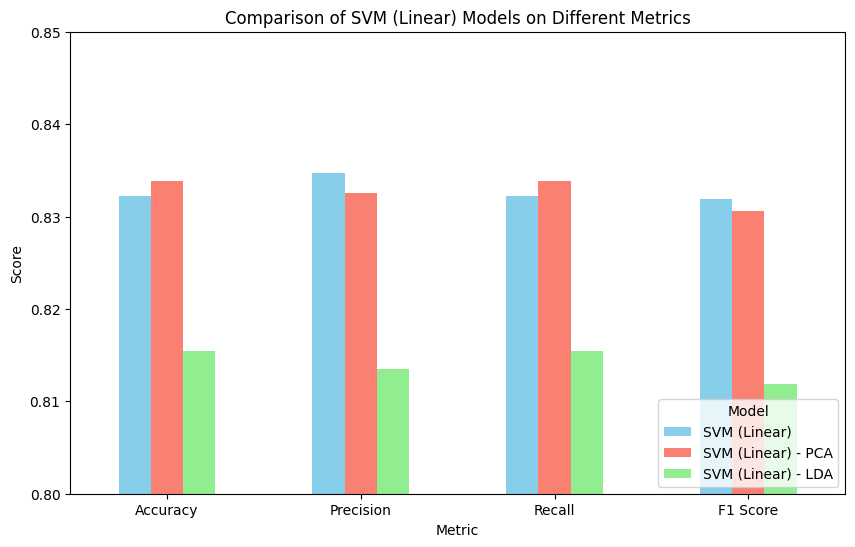

In [337]:
fig, ax = plt.subplots(figsize=(10, 6))
svm_linear_metrics_df.set_index("Metric").plot(kind="bar", ax=ax, color=["skyblue", "salmon", "lightgreen"])
ax.set_title("Comparison of SVM (Linear) Models on Different Metrics")
ax.set_ylabel("Score")
ax.set_xlabel("Metric")
plt.ylim(0.8, 0.85)
plt.xticks(rotation=0)
plt.legend(title="Model", loc='lower right')
plt.show()

**Nhận xét nhanh:**

*  Trong 2 mô hình SVM, bộ dữ liệu sử dụng LDA cho ra kết quả tệ nhất và tệ hơn hẳn khi sử dụng PCA hoặc không giảm chiều.
*  Trong mô hình SVM (RBF), PCA lại cho kết quả tốt hơn hẳn không giảm chiều và trong mô hình SVM (Linear), PCA cho Accuracy và Recall tốt hơn không giảm chiều. Điều này khá là bất thường, tuy nhiên không phải là không thể xảy ra, ta dự đoán nguyên nhân có thể đến từ việc PCA bỏ gần 75% lượng feature ban đầu, điều này có thể giúp giảm thiểu ảnh hưởng của Curse of dimensionality và may mắn làm mô hình tổng quát hóa được tốt hơn, từ đó cho ra kết quả tốt hơn.
*  Mô hình Logistic Regression cho ra kết quả không quá khác biệt giữa 3 phương pháp sử dụng dữ liệu, điều này có lẽ đến từ việc sau khi giảm chiều thì số chiều vẫn quá cao với mô hình Machine Learning cơ bản như Logistic Regression.

In [338]:
runtime_data = {
    "Runtime": ["Training", "Prediction"],
    "Logistic Regression": [logistic_train_time, logistic_pred_time],
    "SVM (Linear)": [svm_linear_train_time, svm_linear_pred_time],
    "SVM (RBF)": [svm_rbf_train_time, svm_rbf_pred_time]    
}

runtime_df = pd.DataFrame(runtime_data)
runtime_df.head().style.hide()

In [341]:
runtime_data = {
    "Runtime - Training": ["PCA", "LDA"],
    "Logistic Regression": [logistic_pca_train_time, logistic_lda_train_time],
    "SVM (Linear)": [svm_linear_pca_train_time, svm_linear_lda_train_time],
    "SVM (RBF)": [svm_rbf_pca_train_time, svm_rbf_lda_train_time]
}

runtime_df = pd.DataFrame(runtime_data)
runtime_df.head().style.hide()

**Nhận xét nhanh:**

*  Mô hình SVM (RBF) tuy có kết quả tốt nhất nhưng rõ ràng thời gian chạy lại gấp hơn 10 lần SVM (Linear) và gấp 30 lần mô hình Logistic Regression.
*  Sau khi giảm chiều, thời gian chạy của các mô hình sử dụng PCA giảm từ 2 đến 3 lần.

Ta có thể thấy tùy vào bài toán, khả năng tính toán của máy và thời gian có thể huấn luyện để cân nhắc sử dụng các mô hình sao cho phù hợp. Bởi vì dù bỏ ra thời gian gấp 30 lần nhưng rõ ràng Logistic Regression cho ra kết quả chỉ thấp hơn khoảng 0.05 điểm trong 4 metric so với mô hình SVM (RBF), nếu ta đang cần deploy 1 mô hình để giải quyết nhanh bài toán đơn giản thì rõ ràng Logistic Regression lại là lựa chọn phù hợp hơn dù kết quả không bằng.